In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')
sns.set(font_scale=1.5)

data_dir = r'C:\Users\James\toronto-open-data-portal'

nbrhood_shp_path = os.path.join(data_dir, 'toronto-nbrhoods-wgs84', 'Neighbourhoods.shp')

#nbrhood_covid_count_path = os.path.join(data_dir, 'toronto-covid19', 'toronto-covid-nbrhood-count-060620.csv')
#nbrhood_covid_count_path = os.path.join(data_dir, 'toronto-covid19', 'toronto-covid-nbrhood-count-060820.csv')
#nbrhood_covid_count_path = os.path.join(data_dir, 'toronto-covid19', 'toronto-covid-nbrhood-count-061520.csv')
#nbrhood_covid_count_path = os.path.join(data_dir,  'toronto-covid19', 'toronto-covid-nbrhood-count-062220.csv')
#nbrhood_covid_count_path = os.path.join(data_dir,  'toronto-covid19', 'toronto-covid-nbrhood-count-062420.csv')
nbrhood_covid_count_path = os.path.join(data_dir,  'toronto-covid19', 'toronto-covid-nbrhood-count-062620.csv')

## Loading COVID-19 Case Data

**Covid19 Counts per Neighbourhood:** number of cases in each of the 140 Toronto Social Planning Neighbourhoods. Downloaded on [DATE INFO] from https://www.toronto.ca/home/covid-19/covid-19-latest-city-of-toronto-news/covid-19-status-of-cases-in-toronto/

In [2]:
covid_counts = pd.read_csv(nbrhood_covid_count_path, encoding='ISO-8859-1')
covid_counts.head()

Neighbourhood Name  Case Count  Rate per 100,000 people
0               Agincourt North          75               257.616872
1  Agincourt South-Malvern West          51               214.673570
2                     Alderwood          36               298.656048
3                         Annex          80               262.071677
4             Banbury-Don Mills          35               126.376602

In [3]:
# The covid data contains a record of counts for missing addresses/postal codes
covid_counts.sort_values(by='Case Count', ascending=False).head(10)

Neighbourhood Name  Case Count  Rate per 100,000 people
140        Missing Address/Postal Code         687                      NaN
45              Glenfield-Jane Heights         467              1531.599488
81   Mount Olive-Silverstone-Jamestown         447              1356.436244
124             West Humber-Clairville         441              1323.847262
33                Downsview-Roding-CFB         410              1169.690745
138            York University Heights         396              1435.146595
58          Islington-City Centre West         343               780.166041
126                             Weston         302              1678.523788
105                              Rouge         286               615.106676
132                             Woburn         279               521.641582

## Loading Toronto Map Data

In [4]:
nbrhood_geo_data = gpd.read_file(nbrhood_shp_path)
nbrhood_geo_cols = pd.read_csv(os.path.join(data_dir, 'toronto-nbrhoods-wgs84',
                                           'Neighbourhoods_fields.csv'), encoding='ISO-8859-1')

print(nbrhood_geo_data.crs)

{'init': 'epsg:4326'}


In [5]:
nbrhood_geo_data.crs = {'init': 'epsg:4326'}
nbrhood_geo_data = nbrhood_geo_data.to_crs({'init':'epsg:3161'})

In [6]:
nbrhood_geo_data.rename(columns=dict(zip(nbrhood_geo_cols.field, nbrhood_geo_cols.name)), inplace=True)
nbrhood_geo_data.head(3)

_id   AREA_ID  AREA_ATTR_ID  PARENT_AREA_ID  AREA_SHORT_CODE  \
0  5601  25886861      25926662           49885               94   
1  5602  25886820      25926663           49885              100   
2  5603  25886834      25926664           49885               97   

   AREA_LONG_CODE             AREA_NAME             AREA_DESC     X     Y  \
0              94         Wychwood (94)         Wychwood (94)  None  None   
1             100  Yonge-Eglinton (100)  Yonge-Eglinton (100)  None  None   
2              97   Yonge-St.Clair (97)   Yonge-St.Clair (97)  None  None   

   LONGITUDE   LATITUDE  OBJECTID   Shape__Area  Shape__Length  \
0 -79.425515  43.676919  16491505  3.217960e+06    7515.779658   
1 -79.403590  43.704689  16491521  3.160334e+06    7872.021074   
2 -79.397871  43.687859  16491537  2.222464e+06    8130.411276   

                                            geometry  
0  POLYGON ((1378793.691 11912529.817, 1378872.49...  
1  POLYGON ((1380607.142 11915332.430, 1380712.37...  
2  POLYGON ((1382386.656 11912898.443, 1382370.61...

In [7]:
# remove the area code and trailing whitespace from the area names
nbrhood_geo_data['AREA_NAME'] = nbrhood_geo_data.AREA_NAME.str.replace('\s\(\d+\)', '')

In [8]:
set(nbrhood_geo_data.AREA_NAME).difference(set(covid_counts['Neighbourhood Name']))

{'Cabbagetown-South St.James Town',
 'North St.James Town',
 'Weston-Pellam Park'}

In [9]:
# identified differences in the covid nbrhood names using Pandas' dataframe.col.str.extractall(REGEX) function
covid_counts.loc[[19, 89, 127,]]

Neighbourhood Name  Case Count  Rate per 100,000 people
19   Cabbagetown-South St. James Town          36               308.509727
89               North St. James Town         183               983.078163
127                Weston-Pelham Park          37               333.393404

In [10]:
# renaming the neighbourhood names in the covid data to the Toronto shapefile conventions
covid_counts.loc[19, 'Neighbourhood Name'] = 'Cabbagetown-South St.James Town'
covid_counts.loc[89, 'Neighbourhood Name'] = 'North St.James Town'
covid_counts.loc[127, 'Neighbourhood Name'] = 'Weston-Pellam Park'

In [11]:
covid_counts.rename(columns={'Neighbourhood Name':'AREA_NAME'}, inplace=True)

In [12]:
covid_counts.set_index('AREA_NAME', inplace=True)
nbrhood_geo_data.set_index('AREA_NAME', inplace=True)

## Proportional Symbol Map of COVID-19 Cases

1. Create a new GeoSeries from the centroids of the neighbourhood polygons
2. Join the new GeoSeries with the Case Count data
3. Define the size of the markers from the number of cases per neighbourhood
4. Plot both GeoPandas objects in the same matplotlib axis

In [13]:
nbrhood_centroids = gpd.GeoDataFrame(nbrhood_geo_data.centroid, columns=['geometry'])
nbrhood_centroids = nbrhood_centroids.join(covid_counts)

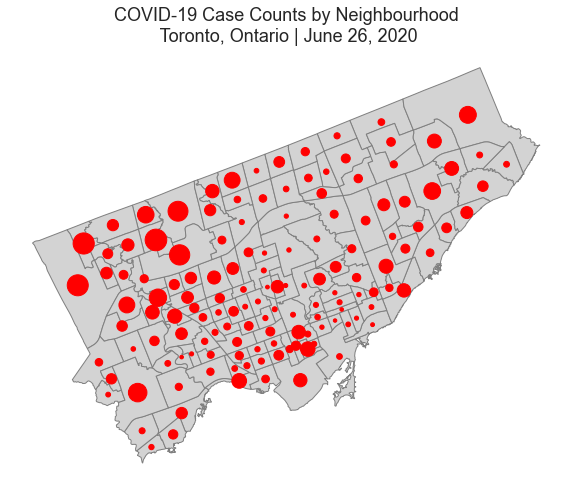

In [14]:
fig, ax = plt.subplots(figsize=(10,8))

# base map
nbrhood_geo_data.plot(ax=ax,
                     facecolor='lightgray',
                     edgecolor='gray')

# symbols layer
ms = nbrhood_centroids['Case Count']

nbrhood_centroids.plot(ax=ax, markersize=ms, color='red', legend=True)

# annotations
ax.set_title('COVID-19 Case Counts by Neighbourhood\n Toronto, Ontario | June 26, 2020')
ax.axis('equal')
ax.set_axis_off()

plt.show();

In [15]:
# subsetting the data in two layers: 5 highest case counts & everyone else
nbrhood_centroids.sort_values(by='Case Count', ascending=False, inplace=True)

highest_counts = nbrhood_centroids.head(5)
lower_counts = nbrhood_centroids.iloc[5:]

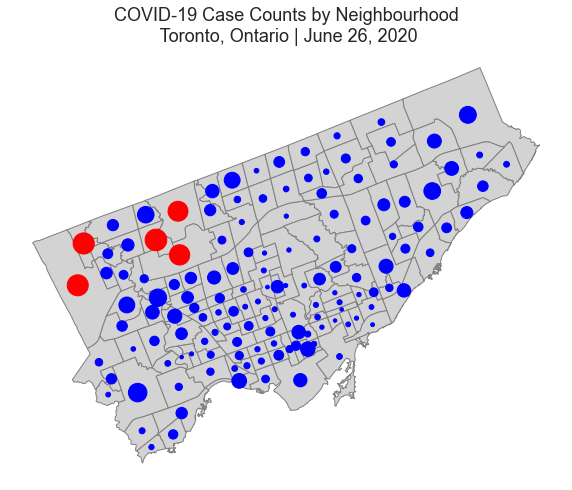

In [16]:
fig, ax = plt.subplots(figsize=(10,8))

# base map
nbrhood_geo_data.plot(ax=ax,
                     facecolor='lightgray',
                     edgecolor='gray')

# symbols layer
ms1 = highest_counts['Case Count']
ms2 = lower_counts['Case Count']

highest_counts.plot(ax=ax, markersize=ms1, color='red', legend=True)
lower_counts.plot(ax=ax, markersize=ms2, color='blue')

# annotations
ax.set_title('COVID-19 Case Counts by Neighbourhood\n Toronto, Ontario | June 26, 2020')
ax.axis('equal')
ax.set_axis_off()

plt.show();

## Choropleth Map of COVID-19 Cases

In [17]:
# joining the covid case count/rate data into the og geopandas frame
nbrhood_geo_data = nbrhood_geo_data.join(covid_counts)

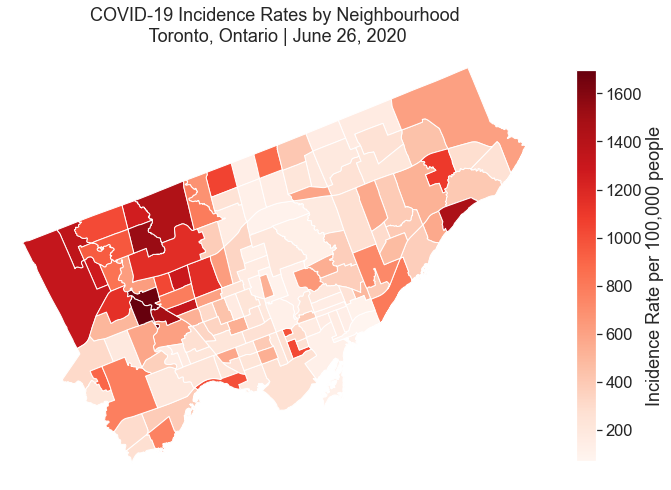

In [18]:
fig, ax = plt.subplots(figsize=(12,8))

nbrhood_geo_data.plot(ax=ax,
                     column='Rate per 100,000 people',
                     cmap='Reds',
                     legend=True,
                     legend_kwds={'label':'Incidence Rate per 100,000 people',
                                  'orientation': 'vertical',
                                  'shrink': 0.9})

ax.set_title('COVID-19 Incidence Rates by Neighbourhood\n Toronto, Ontario | June 26, 2020')
ax.axis('equal')
ax.set_axis_off()

plt.show();

## Interactive Choropleth of Neighbourhood Incidence Rates

In [19]:
import hvplot.pandas

In [22]:
hv_choropleth = nbrhood_geo_data.hvplot(c='Rate per 100,000 people', hover_cols=['Case Count', 'AREA_NAME'], cmap='Reds',
                                        title='COVID-19 Incidence Rates by Neighbourhood\n Toronto, Ontario | June 26, 2020', 
                                        width=800, height=500, )

hvplot.save(hv_choropleth, 'ir_choropleth.html')

In [23]:
hv_choropleth

:Polygons   [x,y]   (Rate per 100,000 people,Case Count,AREA_NAME)